## Introduction

This tutorial will introduce you to the NBA API and show you how to retrieve and work with the data using the many API endpoints the API has to offer. Sports Analytics is rapidly growing field today. Often times in the sports realm, we want to either analyze team and player performance, identify areas of improvement, or also make interesting discoveries to help us better understand the game. In a basketball game specifically, all sorts of data are being collected because there are so many moving parts and the only way to process all this information is with data science!

### Tutorial Content

In this tutorial, we will show how to read API documentation using the NBA API as an example, retrieve data using the [NBA API](https://github.com/swar/nba_api), and do analysis using [Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/) to create visualizations for the data.

We will be working with spatial shot data and gamelog data from the NBA API. The NBA API has [over a hundred different endpoints](https://github.com/swar/nba_api/tree/master/docs/nba_api/stats/endpoints), so it's impossible to go through all of them, but the hope is that you understand how to interact with the API and work with the data by the end of this tutorial.

The following topics will be covered in this tutorial:
- [Installing the libaries](#first-bullet)
- [What is an API? What is an Endpoint?](#second-bullet)
- [Finding Player and Team IDs/Database for Future API Endpoint Request](#third-bullet)
- [How To Call An ```stats.nba.com``` Endpoint](#fourth-bullet)
- [How To Read in the Response of the Endpoint Call ](#fifth-bullet)
- [Example Application: Spatial Analysis - Shot Charts](#sixth-bullet)
    - [Creating the Scatter Shot Plot](#seventh-bullet)
    - [Creating an Animation for Shot Charts](#eigth-bullet)
- [Example Application: Rolling Averages](#ninth-bullet)

## Installing the Libraries <a class="anchor" id="first-bullet"></a>

Before getting started, you'll need to install the various libraries that we will use. These libraries can be installed using ```pip```. 

&emsp;$ pip install --upgrade nba_api pandas requests matplotlib seaborn

Note that the [```requests```](https://docs.python-requests.org/en/master/) library is installed so that ```nba_api``` library can work. We will not need to import the ```requests``` module when we import all the libraries we will use in this tutorial

If you're working in Jupyter Notebook, then you can run the following cell in your notebook to install the various libraries:

In [ ]:
!pip install --upgrade nba_api requests

After you run the installs, make sure the imports below work. For now, we will not be importing the ```nba_api``` library since the endpoints require a slightly more elaborate way to import it, which we will go over in the next section.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as pchs
import matplotlib.animation as animation

## What is an API? What is an Endpoint? <a class="anchor" id="second-bullet"></a>

An **API**, short for **Application Programming Interface**, is a communication tool between two application that allows for data transfer and data requests using code. APIs have **endpoints** that are distinct points of entry in a communication channel between applications. Each endpoint specifies a particular digital location for the API to access and request data from.

## Finding Player and Team IDs/Database for Future API Endpoint Request<a class="anchor" id="third-bullet"></a>

The NBA.com website holds a static database for all active and non-active players and teams in the league. Databases often associate the names of players and teams with an ID number to make working with data much easier and efficient. In your endpoint calls, knowing these IDs will be important as they will often be passed in as parameters for the call. In the NBA's static database, players and teams are associated with a unique ID. To access this database, import the static library:

In [2]:
from nba_api.stats.static import players, teams

To find the ID of a specific player, make the following search:

In [3]:
players.find_players_by_full_name('Damian lillard')

[{'id': 203081,
  'full_name': 'Damian Lillard',
  'first_name': 'Damian',
  'last_name': 'Lillard',
  'is_active': True}]

To find the ID of a specific team, make the following search:

In [4]:
teams.find_teams_by_full_name('Portland Trail Blazers')

[{'id': 1610612757,
  'full_name': 'Portland Trail Blazers',
  'abbreviation': 'POR',
  'nickname': 'Trail Blazers',
  'city': 'Portland',
  'state': 'Oregon',
  'year_founded': 1970}]

To access the player database, make the following command.

In [5]:
#returns a list with the dictionary database of players
players_database = players.get_players() 

To access the team database, make the following command.

In [6]:
#returns a list with the dictionary database of teams
teams_database = teams.get_teams()

## How To Call An ```stats.nba.com``` Endpoint<a class="anchor" id="fourth-bullet"></a>

Now that we have learned how to find IDs for future endpoint calls, let's learn how to use the ```nba_api``` library. The ```nba_api``` library is an API Client package that provides access to the API endpoints on NBA.com. This means our import is **not** as simple as ```import nba_api```. Instead we will have to make a direct import for a specific endpoint on the NBA.com website so that the API knows which endpoint to make requests to. For reference, you can find the [list of nba_api endpoints here](https://github.com/swar/nba_api/tree/master/docs/nba_api/stats/endpoints).

Since we're going to be working with shot data for spatial analysis later, let's look through the list of endpoints that returns spatial shot data. Upon inspection, there is an endpoint called ```shotchartdetail``` that does exactly that. Often times, if you're looking for specific data, reading the names of the endpoint will help. You can also read the [endpoint's documentation for its datasets](https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md#data-sets). 

Let's make the endpoint import for ```shotchartdetail```. The format to import a specific endpoint is: ```from nba_api.stats.endpoints import <endpoint name>```.

In [7]:
from nba_api.stats.endpoints import shotchartdetail

Now let's make a call to the stats endpoint by calling its class. The format to call the class is ```<endpoint name>.<class name>(***kwargs)```. [Endpoints also have other parameters that can be passed in](https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md#parameters), but are not required. To see what input every endpoint parameter requires, [the documentation can be found here](https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/library/parameters.md#ContextMeasure).

Upon [inspection of this endpoint's class](https://github.com/swar/nba_api/blob/master/nba_api/stats/endpoints/shotchartdetail.py), the class name is ```ShotChartDetail```. Judging by the class' ```__init__```, the required arguments for this class call are ```team_id``` and ```player_id```. But let's also pass in arguments for ```season_nullable``` and ```context_measure_simple```. In this example, we'll continue with the IDs we found for Damian Lillard and the Portland Trail Blazers since he plays for that team.

In [8]:
shot_data = shotchartdetail.ShotChartDetail(team_id=1610612757, 
                                            player_id=203081,
                                            season_nullable='2020-21',
                                            context_measure_simple='FGA'
                                           )

print('This returns an object:', shot_data)

This returns an object: <nba_api.stats.endpoints.shotchartdetail.ShotChartDetail object at 0x000001CEC1E3E888>


## How To Read in the Response of the Endpoint Call <a class="anchor" id="fifth-bullet"></a>

The class call above returns an object with the [following class structure](https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints_data_structure.md). In the class structure, you will find multiple functions that return the response in multiple formats. In Python, the most common way to work and view datasets is using dataframes by the ```pandas``` library, so we will be calling ```get_data_frames()``` on the object. This function returns the dataset in a list. So in order to view the dataframe, the following command is used.

In [9]:
shot_df = shot_data.get_data_frames()[0]

shot_df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022000020,26,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,10,49,...,Left Side(L),8-16 ft.,11,-119,15,1,0,20201223,POR,UTA
1,Shot Chart Detail,0022000020,44,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,8,35,...,Left Side Center(LC),24+ ft.,28,-188,214,1,0,20201223,POR,UTA
2,Shot Chart Detail,0022000020,92,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,5,21,...,Center(C),Less Than 8 ft.,1,-11,5,1,0,20201223,POR,UTA
3,Shot Chart Detail,0022000020,231,203081,Damian Lillard,1610612757,Portland Trail Blazers,2,6,16,...,Center(C),24+ ft.,29,-81,283,1,0,20201223,POR,UTA
4,Shot Chart Detail,0022000020,289,203081,Damian Lillard,1610612757,Portland Trail Blazers,2,1,18,...,Right Side Center(RC),24+ ft.,27,89,261,1,0,20201223,POR,UTA


In [10]:
shot_df.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM'],
      dtype='object')

## Example Application: Spatial Analysis - Shot Charts <a class="anchor" id="sixth-bullet"></a>

### Creating the Scatter Shot Plot<a class="anchor" id="seventh-bullet"></a>

Now that we have the data, let's work with this data!

If we inspect the dataframe, each shot has x,y coordinates associated with it. We can visualize shot data by plotting it on the Cartesian Coordinate System. We use [```plt.scatter(**kwargs)```](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) from ```import matplotlib.pyplot as plt``` and then pass in the following columns of the dataframe as arguments: ```LOC_X``` and ```LOC_Y```

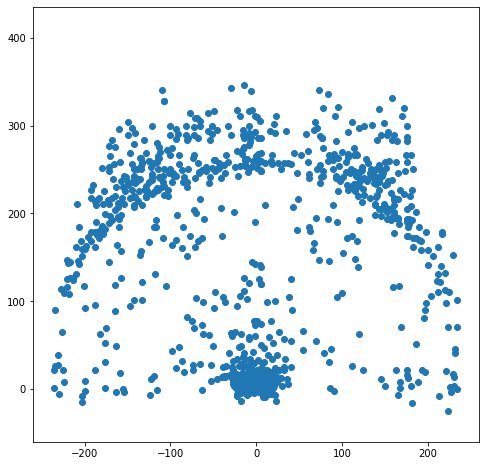

In [11]:
#fix the plot canvas size
plt.figure(figsize=(8,8))
ax = plt.gca()

#plot scatter plots 
plt.scatter(shot_df.LOC_X, shot_df.LOC_Y)

#x and y axis limits
plt.xlim(-260,260)
plt.ylim(-60,435)
plt.show()

This is a good start, but the plot is just a bunch of blue dots. We can sort of make up a mental image of a basketball court from these blue dots, but it would we better if we can draw a basketball court on this plot to make this more visually appealing and comprehensible. Let's now plot the shots by the ```SHOT_ZONE_BASIC``` column, which distinguishes the generalized region the shot was taken in, and mark them by different colored dots. We can do this by using the colormaps that [```import matplotlib.colors as cm```](https://matplotlib.org/stable/tutorials/colors/colormaps.html) has to offer and then assigning a color to each zone.

In [12]:
#show the names of all the zones on the court
shot_df.SHOT_ZONE_BASIC.unique()

array(['Mid-Range', 'Above the Break 3', 'Restricted Area',
       'In The Paint (Non-RA)', 'Left Corner 3', 'Right Corner 3',
       'Backcourt'], dtype=object)

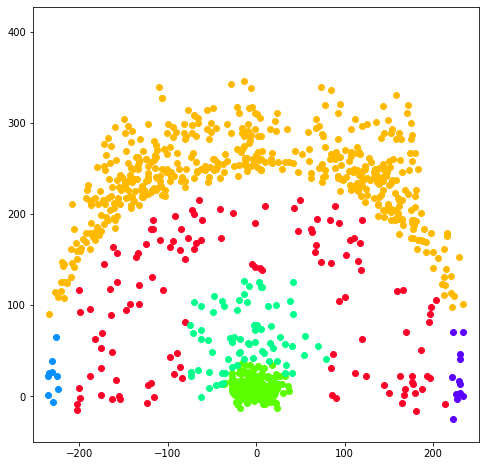

In [13]:
#fix the plot canvas size
plt.figure(figsize=(8,8))
ax = plt.gca()

#define the list of colors to use from a colormap based on the number of different shot zones
colors = cm.gist_rainbow(np.linspace(0, 1, len(shot_df.SHOT_ZONE_BASIC.unique())))

#plot scatter plots 
for shot_zone, color in zip(shot_df.SHOT_ZONE_BASIC.unique(), colors):
    #subset the dataframe by shot zone
    sub_shot_df = shot_df[shot_df['SHOT_ZONE_BASIC'] == shot_zone]
    #plot the subset and pass in its assigned color
    plt.scatter(sub_shot_df.LOC_X, sub_shot_df.LOC_Y, color=color)

#x and y axis limits
plt.xlim(-252.5,252.5)
plt.ylim(-50,427.5)
plt.show()

With the plot above, it's easy to see the different regions of the court. Earlier we imported ```matplotlib.patches as pchs```. This submodule consists of classes called [```Circle(**kwargs)```](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Circle.html), [```Rectangle(**kwargs)```](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html), and [```Arc(**kwargs)```](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Arc.html) that add independent drawings to the plot. We can add these drawings to the ``ax`` of the plot using ```ax.add_patch(<class instance>)``` and draw the court.

In [14]:
#define function to draw the court
def draw(ax):
    #how to change the facecolor
    ax.set_facecolor('black')
    #draw the corner three lines
    for x1, x2 in zip([-220,220],[-250,220]):
        ax.add_patch(pchs.Rectangle((x1, -47.5), 0, 137.5, linewidth=3, color='w'))
        ax.add_patch(pchs.Rectangle((x2, 90), 30, 0, linewidth=3, color='w'))
    #draw the three point line above the break
    ax.add_patch(pchs.Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=3, color='w'))
    #draw the free throw circle
    ax.add_patch(pchs.Arc((0, 142.5), 120, 120, theta1=0, theta2=360, linewidth=3, color='w'))
    #draw the paint box boundaries
    for x, width in zip([-80,-60], [160,120]):
        ax.add_patch(pchs.Rectangle((x, -47.5), width, 190, fill=False, linewidth=3, color='w'))
    #draw paint hashmarks
    for y in [90, 62.5, 37.5, 27.5]:
        ax.add_patch(pchs.Rectangle((-90, y), 10, 0, fill=False, linewidth=3, color='w'))
        ax.add_patch(pchs.Rectangle((80, y), 10, 0, fill=False, linewidth=3, color='w'))
    #draw court boundaries
    ax.add_patch(pchs.Rectangle((-250, -47.5), 500, 470, fill=False, linewidth=3, color='w'))
    #draw the restricted area
    ax.add_patch(pchs.Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=3, color='w'))
    #draw the hoop
    ax.add_patch(pchs.Circle((0, 0), radius=5, linewidth=3, color='w'))
    #draw backboard
    ax.add_patch(pchs.Rectangle((-25, -7.5), 50, -1, linewidth=3, color='w'))
    return ax

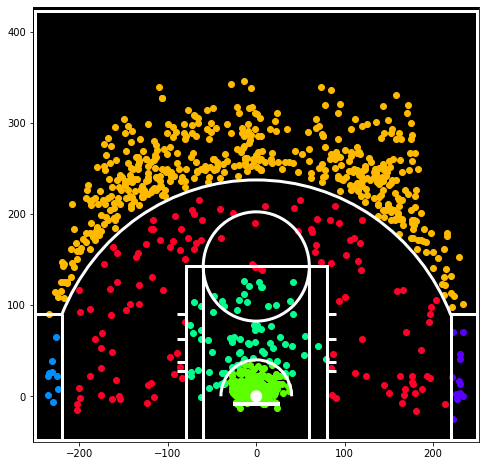

In [15]:
#fix the plot canvas size
plt.figure(figsize=(8,8))

#get current Axes instance on the current figure
ax = plt.gca()

#how to change the facecolor
ax.set_facecolor('black')

#draw the court
ax = draw(ax)

#plot scatter plots 
for shot_zone, color in zip(shot_df.SHOT_ZONE_BASIC.unique(), colors):
    sub_shot_df = shot_df[shot_df['SHOT_ZONE_BASIC'] == shot_zone]
    ax.scatter(sub_shot_df.LOC_X, sub_shot_df.LOC_Y, color=color)

#x and y axis limits
plt.xlim(-252.5,252.5)
plt.ylim(-50,427.5)
plt.show()

### Creating an Animation for Shot Charts<a class="anchor" id="eigth-bullet"></a>

Awesome! As you can see, we've drawn the lines accordingly by using the previous plot as a guide for where certain lines should be. 

Now let's take this plot one step further by doing an animation. We'll do this by analyzing shot data as time goes down in a period. In ```shot_df```, there are two columns: ```MINUTES_REMAINING```, and ```SECONDS_REMAINING```. Using this information, we can create a new column of data that reflects the total amount of time remaining in seconds.

In [16]:
#create a new column for time remaining in seconds
shot_df['TIME_REMAINING'] = ((shot_df['MINUTES_REMAINING'] * 60) + (shot_df['SECONDS_REMAINING']))

shot_df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,TIME_REMAINING
0,Shot Chart Detail,0022000020,26,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,10,49,...,8-16 ft.,11,-119,15,1,0,20201223,POR,UTA,649
1,Shot Chart Detail,0022000020,44,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,8,35,...,24+ ft.,28,-188,214,1,0,20201223,POR,UTA,515
2,Shot Chart Detail,0022000020,92,203081,Damian Lillard,1610612757,Portland Trail Blazers,1,5,21,...,Less Than 8 ft.,1,-11,5,1,0,20201223,POR,UTA,321
3,Shot Chart Detail,0022000020,231,203081,Damian Lillard,1610612757,Portland Trail Blazers,2,6,16,...,24+ ft.,29,-81,283,1,0,20201223,POR,UTA,376
4,Shot Chart Detail,0022000020,289,203081,Damian Lillard,1610612757,Portland Trail Blazers,2,1,18,...,24+ ft.,27,89,261,1,0,20201223,POR,UTA,78


Now that we have the ```TIME_REMAINING``` column, let's examine its distribution by plotting a histogram with ```seaborn```.

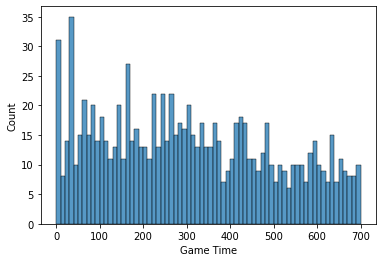

In [17]:
#get list of all game times
time_remaining_lst = shot_df.TIME_REMAINING.to_list()

#create bins
bins = [x for x in range(0, max(time_remaining_lst), 10)]

#plot histogram of game time
sns.histplot(time_remaining_lst, bins=bins)
plt.xlabel('Game Time')
plt.show()

In the histogram above, we binned the data by intervals of 10 seconds. Judging by the distribution alone, this seems like a solid animation to base off of because each 10 second interval has a decent sample size of shots. For the animation then, we will be plotting shots by decending 10 second intervals from the 12 minute mark, which is the total time in a period. This requires some domain knowledge, but can also be seen upon inspection of the ```MINUTES_REMAINING``` column. 

Now by using the [```animation```](https://matplotlib.org/stable/api/animation_api.html) submodule of ```matplotlib```, we  create the animation by calling its class ```FuncAnimation(**kwargs)```. In this class call, we pass in ```fig```, which is the figure object of the plot, and our function ```run```, which updates the plot. We also specify ```interval=500``` for a half-second delay between frames and then the maximum number of ```frames``` needed.

In [18]:
#define and create plot
fig, ax = plt.subplots(figsize=(8,8))

#get number of frames for the animations
time_steps = max(time_remaining_lst) // 10 + 1

#set time interval to subset dataframe by 
time_interval = 10

#division by zero fix
def divide(num, den):
    try:
        return round(num / den * 100, 1)
    except:
        return 0

#updates animation
def run(i):
    #clear the plot figure
    fig.clear()
    #create new plot
    ax = fig.add_subplot(111, aspect='equal', xlim=(-252.5,252.5), ylim=(-50,427.5))
    #draw the court again
    ax = draw(ax)
    #indicate animation time steps
    start_time = i*time_interval
    end_time = (i+1)*time_interval
    #subset the dataframe given a timeframe
    temp_df = shot_df[(shot_df['TIME_REMAINING'] >= start_time) & (shot_df['TIME_REMAINING'] <= end_time)]
    #subset the temp_df by makes and misses
    makes_df = temp_df[temp_df['SHOT_MADE_FLAG'] == 1]
    miss_df = temp_df[temp_df['SHOT_MADE_FLAG'] == 0]
    #plot makes and misses separately
    ax.scatter(makes_df.LOC_X, makes_df.LOC_Y, c='green', marker = ".", s=100)
    ax.scatter(miss_df.LOC_X, miss_df.LOC_Y, c='red', marker = "x", s=50)
    #add text to animation
    ax.text(0.05, 0.90, 'Time Remaining in Quarter: %02d:%02d-%02d:%02d' % (start_time//60, start_time%60, 
                                                                 end_time//60, end_time%60), 
            c='white', transform=ax.transAxes, size=15)
    #calculate field goal percentage in that time span and display fg% as text
    ax.text(0.05, 0.85, 'FG%%: %.1f' % divide(makes_df.shape[0], temp_df.shape[0]),
            c='w', transform=ax.transAxes, size=15)
    
#edit plot labels and axis 
plt.xlim(-252.5,252.5)
plt.ylim(-50,427.5)

#save animation object, and then save as .gif
shot_anim = animation.FuncAnimation(fig, run, interval=500, frames=range(time_steps,-1,-1))
shot_anim.save('animation.gif', writer='pillow')

#close the animation figure
plt.close(shot_anim._fig)

Notice how once we call the ```FuncAnimation``` to make the animation, we save the resultant animation object as ```shot_anim``` and then call its ```.save(<name>.gif``` method to save the animation as a ```.gif``` file. We can read in the ```.gif``` file and display it by running the code below. This animation is a perfect way to visualize shooting tendencies and efficiency as time goes down in the quarter.

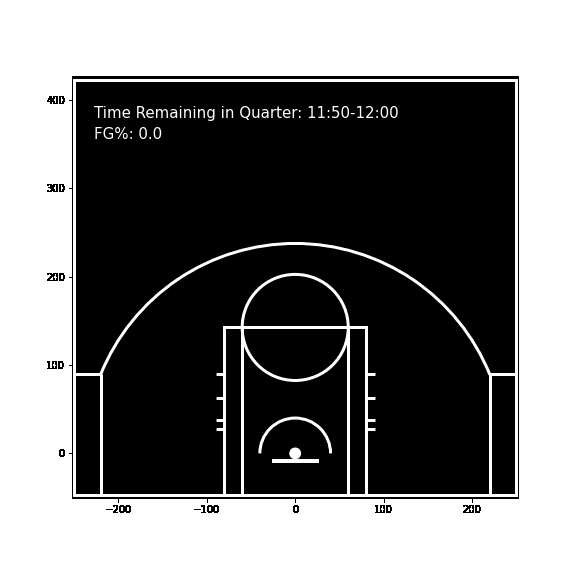

In [19]:
#this function loads the .gif file of the animation we saved earlier and displays it
from IPython.display import Image
with open('animation.gif','rb') as file:
    display(Image(file.read()))

## Example Application: Rolling Averages<a class="anchor" id="ninth-bullet"></a>

In this exampple, we will be looking at player gamelog data and consider how we can utilize ```pandas``` to do a rolling 10-game averages for a career's worth of gamelog data. The following example still uses the ```nba_api``` to pull data, but it also uses the ```time``` library to put a delay in between API endpoints requests. The goal is to work with datasets by performing multiple operations and then creating a final visualization to communicate the rolling 10-game average results.

Let's pull a career's worth of gamelog data for Chris Paul.

In [20]:
#used to avoid timeouts that could be caused by multiple fast timeout requests
import time

#specify endpoints used
from nba_api.stats.endpoints import commonplayerinfo, playergamelog

#find ids
player_id = players.find_players_by_full_name('Chris Paul')[0]['id']

#find player info using their player id
player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id)
df = player_info.get_data_frames()[0]

#show types of data in player info
print(df.columns)

#show player_info
df.head()

Index(['PERSON_ID', 'FIRST_NAME', 'LAST_NAME', 'DISPLAY_FIRST_LAST',
       'DISPLAY_LAST_COMMA_FIRST', 'DISPLAY_FI_LAST', 'PLAYER_SLUG',
       'BIRTHDATE', 'SCHOOL', 'COUNTRY', 'LAST_AFFILIATION', 'HEIGHT',
       'WEIGHT', 'SEASON_EXP', 'JERSEY', 'POSITION', 'ROSTERSTATUS',
       'GAMES_PLAYED_CURRENT_SEASON_FLAG', 'TEAM_ID', 'TEAM_NAME',
       'TEAM_ABBREVIATION', 'TEAM_CODE', 'TEAM_CITY', 'PLAYERCODE',
       'FROM_YEAR', 'TO_YEAR', 'DLEAGUE_FLAG', 'NBA_FLAG', 'GAMES_PLAYED_FLAG',
       'DRAFT_YEAR', 'DRAFT_ROUND', 'DRAFT_NUMBER'],
      dtype='object')


,PERSON_ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,...,TEAM_CITY,PLAYERCODE,FROM_YEAR,TO_YEAR,DLEAGUE_FLAG,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER
0,101108,Chris,Paul,Chris Paul,"Paul, Chris",C. Paul,chris-paul,1985-05-06T00:00:00,Wake Forest,USA,...,Phoenix,chris_paul,2005,2020,N,Y,Y,2005,1,4


In order to pull the data, we'll need to know when Chris Paul started playing and when Chris Paul stopped playing or if he's still playing. With the dataframe returned above, we can see that the information lies in columns: ```FROM_YEAR``` and ```TO_YEAR```. Let's save that info into a variable and then use that information for our loop to pull multiple API requests.

In [21]:
#get the year they first began playing in the NBA and the year of their current/last season in the NBA 
from_year = df.iloc[0]['FROM_YEAR']
to_year = df.iloc[0]['TO_YEAR']

#create empty dataframe
career_gamelog_df = pd.DataFrame()

#loop through every season of their career to create multiple API requests for gamelog data
for season in range(from_year, to_year+1):
    #create season parameter
    season_param = str(season) + '-' + str(season)[2:]
    #request data
    gamelog_data = playergamelog.PlayerGameLog(player_id=player_id, season=season_param)
    #get dataframe and append it to the career dataframe
    gamelog_df = gamelog_data.get_data_frames()[0]
    career_gamelog_df = pd.concat([career_gamelog_df, gamelog_df])
    #put delay in between requests
    time.sleep(5)
    
career_gamelog_df.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22005,101108,0020501229,"APR 19, 2006",NOK @ LAL,L,24,3,9,0.333,...,2,2,7,2,0,3,3,7,-6,0
1,22005,101108,0020501210,"APR 17, 2006",NOK @ PHX,L,29,4,10,0.400,...,3,4,5,3,0,3,1,11,-14,0
2,22005,101108,0020501202,"APR 16, 2006",NOK @ SAC,L,28,5,8,0.625,...,1,1,7,2,0,1,1,12,-6,0
3,22005,101108,0020501183,"APR 14, 2006",NOK vs. UTA,L,36,2,10,0.200,...,3,4,7,1,0,1,2,11,-7,0
4,22005,101108,0020501169,"APR 12, 2006",NOK vs. SEA,W,37,5,14,0.357,...,1,3,6,2,0,3,2,21,-1,0


In [22]:
#convert GAME_DATE to datetime type for easy usage when working with data
career_gamelog_df['GAME_DATE'] = pd.to_datetime(career_gamelog_df['GAME_DATE'])

#sort by game date just in case and reset index
career_gamelog_df = career_gamelog_df.sort_values(by='GAME_DATE', ascending=True).reset_index(drop=True)

career_gamelog_df.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22005,101108,0020500025,2005-11-01,NOK vs. SAC,W,34,3,7,0.429,...,8,8,4,2,1,4,0,13,23,0
1,22005,101108,0020500006,2005-11-02,NOK @ CLE,L,29,5,11,0.455,...,4,5,3,2,0,4,1,13,-19,0
2,22005,101108,0020500038,2005-11-05,NOK @ HOU,W,34,6,14,0.429,...,3,4,8,2,0,1,4,15,4,0
3,22005,101108,0020500063,2005-11-09,NOK vs. ORL,L,35,4,13,0.308,...,3,4,4,3,0,0,4,10,-6,0
4,22005,101108,0020500085,2005-11-12,NOK vs. DAL,L,36,10,14,0.714,...,2,3,5,1,0,5,4,26,-11,0


Now that we have the data, it's time to work. First, we take field goal attempts, 3pt attempts, and free-throw attempts and do a rolling 10-game sum using ```.rolling().sum()```. After taking the rolling 10-game sum, the 10 game rolling average is simply calculated by doing makes over misses. This methodology is slightly different from the next part because we're dealing with sample size.

In [23]:
#calculate rolling shooting averages, requires summation of field goals made and attempts and not averaging out percentage by game
shot_rolling_df = career_gamelog_df[['FGM','FGA','FG3M','FG3A','FTM','FTA']].rolling(10, min_periods=1).sum()

#calculate 10-game shooting percentages
shot_rolling_df['FG%'] = round(shot_rolling_df['FGM'] / shot_rolling_df['FGA'] * 100, 1)
shot_rolling_df['FG3%'] = round(shot_rolling_df['FG3M'] / shot_rolling_df['FG3A'] * 100, 1)
shot_rolling_df['FT%'] = round(shot_rolling_df['FTM'] / shot_rolling_df['FTA'] * 100, 1)

shot_rolling_df.head()

,FGM,FGA,FG3M,FG3A,FTM,FTA,FG%,FG3%,FT%
0,3.0,7.0,1.0,3.0,6.0,6.0,42.9,33.3,100.0
1,8.0,18.0,2.0,7.0,8.0,8.0,44.4,28.6,100.0
2,14.0,32.0,3.0,12.0,10.0,11.0,43.8,25.0,90.9
3,18.0,45.0,3.0,13.0,12.0,13.0,40.0,23.1,92.3
4,28.0,59.0,5.0,19.0,16.0,18.0,47.5,26.3,88.9


For normal counting stats, we can take a rolling 10-game average by using ```.rolling().mean()```.

In [24]:
#calculate 10-game rolling average for counting stats and plus-mins
counts_rolling_df = career_gamelog_df[['REB','AST','STL','BLK',
                                       'TOV','PTS','PLUS_MINUS']].rolling(10, min_periods=1).mean()

counts_rolling_df.head()

,REB,AST,STL,BLK,TOV,PTS,PLUS_MINUS
0,8.000000,4.00,2.00,1.000000,4.00,13.000000,23.000000
1,6.500000,3.50,2.00,0.500000,4.00,13.000000,2.000000
2,5.666667,5.00,2.00,0.333333,3.00,13.666667,2.666667
3,5.250000,4.75,2.25,0.250000,2.25,12.750000,0.500000
4,4.800000,4.80,2.00,0.200000,2.80,15.400000,-1.800000


Now let's plot the rolling 10-game averages using ```plt.plot(**kwargs)```

In [25]:
#create an array for number of games
x = np.linspace(0, career_gamelog_df.shape[0], career_gamelog_df.shape[0])

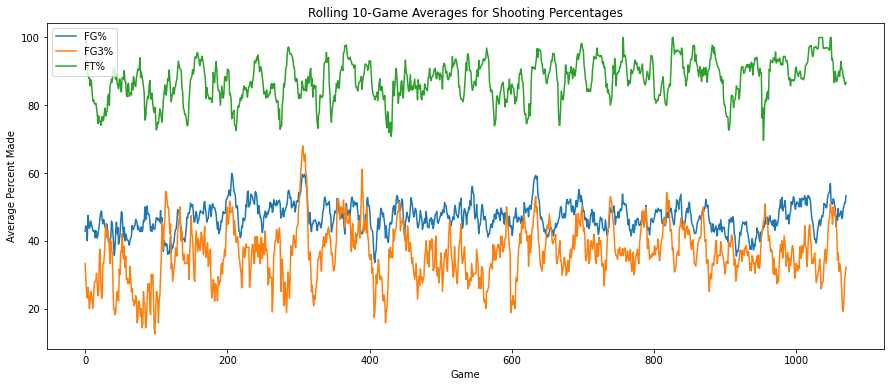

In [26]:
#create figure
plt.figure(figsize=(15,6))

#plot date vs. rolling 10-game average for shooting percentages
for column in shot_rolling_df.columns[6:]:
    plt.plot(x, shot_rolling_df[column], linestyle='-', label=column)

#edit plot properties
plt.legend(loc='upper left')
plt.title('Rolling 10-Game Averages for Shooting Percentages')
plt.xlabel('Game')
plt.ylabel('Average Percent Made')
plt.show()

Plus-Minus (+/-) data in the NBA Realm is useful in measuring a player's impact when in game. In the plot below, we draw a polynomial line of fit to detect changes in player impact throughout their career.

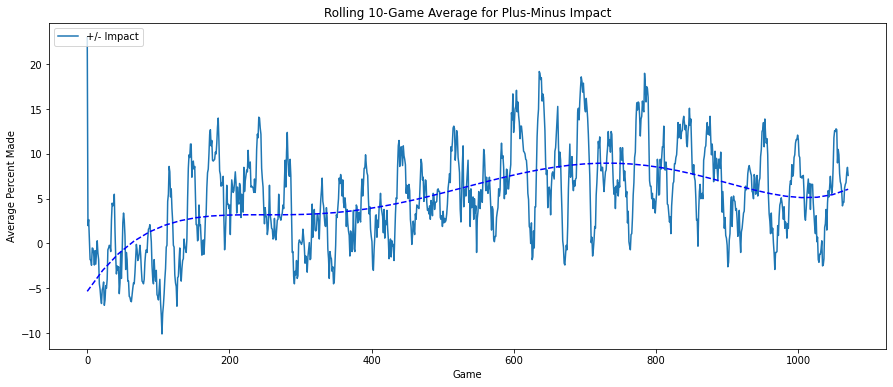

In [27]:
#create figure
plt.figure(figsize=(15,6))

#plot date vs. rolling 10-game average for Plus-Minus (+/-) impact
plt.plot(x, counts_rolling_df['PLUS_MINUS'], linestyle='-', label='+/- Impact')

#create a polynomial line of fit 
coefficients = np.polyfit(x, counts_rolling_df['PLUS_MINUS'], 5)
poly = np.poly1d(coefficients)
new_x = np.linspace(x[0], x[-1])
new_y = poly(new_x)
plt.plot(new_x, new_y, linestyle='--', c ='b')

#edit plot properties
plt.legend(loc='upper left')
plt.title('Rolling 10-Game Average for Plus-Minus Impact')
plt.xlabel('Game')
plt.ylabel('Average Percent Made')
plt.show()

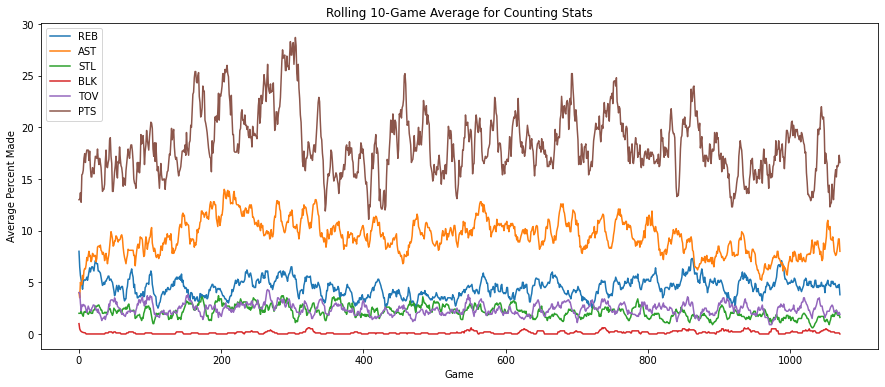

In [28]:
#create figure
plt.figure(figsize=(15,6))

#plot date vs. rolling 10-game average of counting stats
for column in counts_rolling_df.columns[:-1]:
    plt.plot(x, counts_rolling_df[column], linestyle='-', label=column)

#edit plot properties
plt.legend(loc='upper left')
plt.title('Rolling 10-Game Average for Counting Stats')
plt.xlabel('Game')
plt.ylabel('Average Percent Made')
plt.show()

## Summary and References

This tutorial showed you how to retrieve data through the NBA API and previewed some of the few ways in which sports data can be utilized. Libraries used in this tutorial are:

- NBA API: https://github.com/swar/nba_api
- Matplotlib: https://matplotlib.org/
- Seaborn: https://seaborn.pydata.org
- Pandas: https://pandas.pydata.org/